# Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import os
import math
import copy

In [2]:
from google.colab import drive

mount = "/content/drive"
drive.mount(mount)
project_dir = f"{mount}/MyDrive/mmml/project"

os.makedirs(project_dir, exist_ok=True)
print(f"Using project directory: {project_dir}")

Mounted at /content/drive
Using project directory: /content/drive/MyDrive/mmml/project


# Models

In [3]:
class DenseNetwork(nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_dims: list[int],
        output_dim: int,
        dropout_rate: float = 0.2,
    ):
        super(DenseNetwork, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        layers = []
        current_dim = input_dim

        layers.append(nn.Flatten())

        layers.append(nn.Linear(current_dim, hidden_dims[0]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_rate))
        current_dim = hidden_dims[0]

        for i in range(len(hidden_dims) - 1):
            layers.append(nn.Linear(current_dim, hidden_dims[i + 1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            current_dim = hidden_dims[i + 1]

        layers.append(nn.Linear(current_dim, output_dim))

        self.sequential = nn.Sequential(*layers)

    def forward(self, x):
        return self.sequential(x)

# Trainer

In [4]:
class ModelTrainer:
    def __init__(
        self,
        model: nn.Module,
        train_loader: DataLoader,
        val_loader: DataLoader,
        criterion: nn.Module,
        optimizer: torch.optim.Optimizer,
        device: torch.device,
        save_dir: str | None,
    ):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.save_dir = save_dir

        if save_dir is not None:
            os.makedirs(self.save_dir, exist_ok=True)
            print(f"Model will be saved in: {self.save_dir}")
        else:
            print("Model will not be saved to disk")


    def train_epoch(self, accumulate_gradients: bool = False) -> tuple[float, float]:
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, targets in self.train_loader:
            inputs, targets = inputs.to(self.device), targets.to(self.device)

            self.optimizer.zero_grad()

            outputs = self.model(inputs)
            loss = self.criterion(outputs, targets)

            loss.backward()
            if accumulate_gradients:
                self.model.accumulate_gradients()
            self.optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        epoch_loss = running_loss / total if total > 0 else 0.0
        epoch_acc = correct / total if total > 0 else 0.0
        return epoch_loss, epoch_acc

    def validate(self) -> tuple[float, float]:
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, targets in self.val_loader:
                inputs, targets = inputs.to(self.device), targets.to(self.device)

                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)

                running_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        val_loss = running_loss / total if total > 0 else 0.0
        val_acc = correct / total if total > 0 else 0.0
        return val_loss, val_acc

    def train(self, epochs: int, early_stopping_patience: int | None = None, accumulate_gradients: bool = False) -> dict[str, list[float]]:
        history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

        best_val_loss = float("inf")
        patience_counter = 0
        best_epoch = 0

        for epoch in range(1, epochs + 1):
            train_loss, train_acc = self.train_epoch(accumulate_gradients=accumulate_gradients)
            val_loss, val_acc = self.validate()

            history["train_loss"].append(train_loss)
            history["train_acc"].append(train_acc)
            history["val_loss"].append(val_loss)
            history["val_acc"].append(val_acc)

            print(
                f"Epoch {epoch}/{epochs}: "
                f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
                f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
            )

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_epoch = epoch
                patience_counter = 0
                if self.save_dir is not None:
                    self.save_model("best_model.pt")
            else:
                patience_counter += 1

            if (
                early_stopping_patience is not None
                and patience_counter >= early_stopping_patience
            ):
                print(
                    f"Early stopping triggered after {epoch} epochs. Best validation loss {best_val_loss:.4f} at epoch {best_epoch}."
                )
                break

        if self.save_dir:
            self.save_model("final_model.pt")

        return history

    def save_model(self, filename: str):
        model_path = os.path.join(self.save_dir, filename)
        model_info = {
            'model_class': self.model.__class__.__name__,
            'input_dim': getattr(self.model, 'input_dim', None),
            'output_dim': getattr(self.model, 'output_dim', None),
            'hidden_dims': getattr(self.model, 'hidden_dims', None),
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
        }
        try:
            torch.save(model_info, model_path)
            print(f"Model saved to {model_path}")
        except Exception as e:
             print(f"Error saving model to {model_path}: {e}")


    def load_model(self, filename: str):
        model_path = os.path.join(self.save_dir, filename)
        if not os.path.exists(model_path):
            print(f"Model file {model_path} does not exist.")
            return False

        try:
            model_info = torch.load(model_path, map_location=self.device)

            self.model.load_state_dict(model_info["model_state_dict"])
            try:
                self.optimizer.load_state_dict(model_info["optimizer_state_dict"])
            except ValueError as e:
                print(f"Warning: Could not load optimizer state dict, possibly due to model/optimizer changes: {e}")
                print("Optimizer state not loaded. Consider re-initializing the optimizer.")

            print(f"Model loaded from {model_path}")
            self.model.to(self.device)
            return True
        except Exception as e:
             print(f"Error loading model from {model_path}: {e}")
             return False

    def plot_history(self, history: dict[str, list[float]], save_filename="training_history.png"):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        epochs_ran = range(1, len(history['train_loss']) + 1)

        ax1.plot(epochs_ran, history["train_loss"], label="Train Loss")
        ax1.plot(epochs_ran, history["val_loss"], label="Validation Loss")
        ax1.set_title("Loss")
        ax1.set_xlabel("Epoch")
        ax1.set_ylabel("Loss")
        ax1.legend()
        ax1.grid(True)

        ax2.plot(epochs_ran, history["train_acc"], label="Train Accuracy")
        ax2.plot(epochs_ran, history["val_acc"], label="Validation Accuracy")
        ax2.set_title("Accuracy")
        ax2.set_xlabel("Epoch")
        ax2.set_ylabel("Accuracy")
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()
        save_path = os.path.join(self.save_dir, save_filename)
        try:
            plt.savefig(save_path)
            print(f"Training history plot saved to {save_path}")
        except Exception as e:
            print(f"Error saving plot to {save_path}: {e}")
        plt.show()

# Evaluation functions

In [5]:
def evaluate_model(model, test_loader, criterion, device, num_classes, print_more: bool = True):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    class_correct = [0] * num_classes
    class_total = [0] * num_classes

    with torch.no_grad():
        for inputs, targets in test_loader:
            batch_size = inputs.size(0)
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            for i in range(batch_size):
                label = targets[i].item()
                if 0 <= label < num_classes:
                    class_total[label] += 1
                    if predicted[i] == label:
                        class_correct[label] += 1
                else:
                    print(f"Warning: Encountered invalid label {label} during evaluation.")


    test_loss = test_loss / total if total > 0 else 0.0
    test_acc = correct / total if total > 0 else 0.0
    if print_more:
        print(f"\n--- Test Set Evaluation ---")
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f} ({correct}/{total})")

        print("\nClass-specific Accuracy:")
        for i in range(num_classes):
            if class_total[i] > 0:
                accuracy = 100 * class_correct[i] / class_total[i]
                print(f"  Class {i}: {accuracy:.2f}% ({class_correct[i]}/{class_total[i]})")

    return test_loss, test_acc


def visualize_predictions(model, test_loader, device, num_samples=10, save_dir=".", save_filename="predictions.png"):
    model.eval()
    dataiter = iter(test_loader)
    try:
        images, labels = next(dataiter)
    except StopIteration:
        print("Test loader is empty, cannot visualize predictions.")
        return

    num_samples = min(num_samples, images.size(0))
    if num_samples == 0:
        print("No samples available in the first batch to visualize.")
        return

    images = images[:num_samples].to(device)
    labels = labels[:num_samples]
    outputs = model(images)
    _, predictions = torch.max(outputs, 1)

    images_cpu = images.cpu()

    fig = plt.figure(figsize=(max(12, num_samples * 1.5), 4))
    for i in range(num_samples):
        ax = fig.add_subplot(1, num_samples, i + 1, xticks=[], yticks=[]) # More compact
        img_tensor = images_cpu[i] # Shape: (C, H, W)
        img_np = img_tensor.numpy()

        if img_np.shape[0] == 1:
            img_to_show = np.squeeze(img_np, axis=0)
            cmap = "gray"
        else:
            # (C, H, W) -> (H, W, C)
            img_to_show = np.transpose(img_np, (1, 2, 0))
            img_to_show = np.clip(img_to_show, 0, 1)
            cmap = None # matplotlib will handle colors for us

        plt.imshow(img_to_show, cmap=cmap)

        ax.set_title(f"Pred: {predictions[i].item()}\nTrue: {labels[i].item()}", fontsize=10)

    plt.tight_layout(pad=0.5)
    save_path = os.path.join(save_dir, save_filename)
    try:
        plt.savefig(save_path)
        print(f"Predictions visualization saved to {save_path}")
    except Exception as e:
        print(f"Error saving predictions plot: {e}")

    plt.show()

In [6]:
def get_model_size(model: nn.Module) -> float:
    total_params = sum(p.numel() for p in model.parameters())
    bytes_size = total_params * 4  # 4 bytes per float32
    mib_size = bytes_size / (1024 * 1024)
    return mib_size

def compare_models(model, test_loader, criterion, device, num_classes, create_model, coefs: list[float], coef_name: str):
    loss, acc = evaluate_model(model, test_loader, criterion, device, num_classes, print_more=False)
    orig_size = get_model_size(model)
    coef_name_len = len(coef_name)
    print(f"| {coef_name} | Size (MiB) | Size (% of orig) | Loss  | Accuracy |")
    print(f"| {'Original model': <{coef_name_len}} | {orig_size: <10.3f} | 100%             | {loss: <5.3f} | {acc: <8.3f} |")
    for coef in coefs:
        cmp_model = create_model(coef)
        loss, acc = evaluate_model(cmp_model, test_loader, criterion, device, num_classes, print_more=False)
        size = get_model_size(cmp_model)
        print(f"| {coef: <{coef_name_len}%} | {size: <10.3f} | {size/orig_size: <16.3%} | {loss: <5.3f} | {acc: <8.3f} |")

# Dataset loading functions

In [7]:
def calculate_mean_std(dataset: Dataset) -> tuple[torch.Tensor, torch.Tensor]:
    loader = DataLoader(dataset, batch_size=100, shuffle=False, num_workers=2)
    num_channels = 0
    mean = torch.tensor(0.)
    std = torch.tensor(0.)
    total_samples = 0

    print("Calculating dataset mean and std...")
    first_batch, _ = next(iter(loader))
    num_channels = first_batch.size(1)
    mean = torch.zeros(num_channels)
    std = torch.zeros(num_channels)

    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, num_channels, -1)
        mean += images.mean(dim=[0, 2]) * batch_samples
        std += images.std(dim=[0, 2]) * batch_samples
        total_samples += batch_samples

    mean /= total_samples
    std /= total_samples
    print(f"Calculated - Mean: {mean.tolist()}, Std: {std.tolist()}")
    return mean, std

def get_dataset(dataset_name: str, data_root: str = "./data", val_split: float = 0.2) -> dict:
    dataset_name = dataset_name.lower()
    transform_initial = transforms.Compose([transforms.ToTensor()])

    if dataset_name == "mnist":
        temp_train_dataset = datasets.MNIST(root=data_root, train=True, download=True, transform=transform_initial)
        test_dataset_raw = datasets.MNIST(root=data_root, train=False, download=True, transform=transform_initial)
        num_classes = 10
    elif dataset_name == "cifar10":
        temp_train_dataset = datasets.CIFAR10(root=data_root, train=True, download=True, transform=transform_initial)
        test_dataset_raw = datasets.CIFAR10(root=data_root, train=False, download=True, transform=transform_initial)
        num_classes = 10
    else:
        print(f"Unsupported dataset: {dataset_name}")
        return {}

    img, _ = temp_train_dataset[0]
    C, H, W = img.shape

    if dataset_name == "mnist":
        mean, std = torch.tensor([0.1307]), torch.tensor([0.3081])
    elif dataset_name == "cifar10":
        mean, std = torch.tensor([0.4914, 0.4822, 0.4465]), torch.tensor([0.2023, 0.1994, 0.2010])
    else:
        print(f"Using calculated mean/std for {dataset_name}")
        mean, std = calculate_mean_std(temp_train_dataset)


    transform_final = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=mean.tolist(), std=std.tolist())
    ])

    if dataset_name == "mnist":
        train_val_dataset = datasets.MNIST(root=data_root, train=True, download=False, transform=transform_final)
        test_dataset = datasets.MNIST(root=data_root, train=False, download=False, transform=transform_final)
    elif dataset_name == "cifar10":
        train_val_dataset = datasets.CIFAR10(root=data_root, train=True, download=False, transform=transform_final)
        test_dataset = datasets.CIFAR10(root=data_root, train=False, download=False, transform=transform_final)

    num_train_val = len(train_val_dataset)
    indices = list(range(num_train_val))
    split = int(np.floor(val_split * num_train_val))
    np.random.shuffle(indices)
    train_idx, val_idx = indices[split:], indices[:split]

    train_dataset = Subset(train_val_dataset, train_idx)
    val_dataset = Subset(train_val_dataset, val_idx)

    print(f"Dataset: {dataset_name.upper()}")
    print(f"  Image Dimensions: C={C}, H={H}, W={W}")
    print(f"  Number of Classes: {num_classes}")
    print(f"  Training samples: {len(train_dataset)}")
    print(f"  Validation samples: {len(val_dataset)}")
    print(f"  Test samples: {len(test_dataset)}")
    print(f"  Normalization - Mean: {mean.tolist()}, Std: {std.tolist()}")


    return {
        "train": train_dataset,
        "validation": val_dataset,
        "test": test_dataset,
        "num_classes": num_classes,
        "channels": C,
        "height": H,
        "width": W,
        "transform": transform_final
    }


def get_class_subset(dataset, classes_to_keep):
    if isinstance(dataset, Subset):
        original_dataset = dataset.dataset
        original_indices = dataset.indices

        subset_indices = []
        for idx in original_indices:
            _, label = original_dataset[idx]
            if label in classes_to_keep:
                subset_indices.append(idx)

        return Subset(original_dataset, subset_indices)
    else:
        indices = []
        for i in range(len(dataset)):
            _, label = dataset[i]
            if label in classes_to_keep:
                indices.append(i)

        return Subset(dataset, indices)

# Setup

In [8]:
torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [9]:
DATASET_NAME = "mnist" # Also can be "cifar10"
DATA_ROOT = "./data"
BATCH_SIZE = 64
LEARNING_RATE = 0.001
EPOCHS = 10
EARLY_STOPPING_PATIENCE = 3
HIDDEN_DIMS = [256, 128]
DROPOUT_RATE = 0.3
MODEL_SAVE_SUBDIR = f"model_{DATASET_NAME}_dense"

run_save_dir = os.path.join(project_dir, MODEL_SAVE_SUBDIR)
os.makedirs(run_save_dir, exist_ok=True)

In [10]:
dataset_info = get_dataset(DATASET_NAME, data_root=DATA_ROOT, val_split=0.2)
train_dataset = dataset_info["train"]
val_dataset = dataset_info["validation"]
test_dataset = dataset_info["test"]
num_classes = dataset_info["num_classes"]
C, H, W = dataset_info["channels"], dataset_info["height"], dataset_info["width"]

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True if device=="cuda" else False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True if device=="cuda" else False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True if device=="cuda" else False)

input_dim = C * H * W
output_dim = num_classes

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 496kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.55MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.76MB/s]

Dataset: MNIST
  Image Dimensions: C=1, H=28, W=28
  Number of Classes: 10
  Training samples: 48000
  Validation samples: 12000
  Test samples: 10000
  Normalization - Mean: [0.1307000070810318], Std: [0.30809998512268066]


# Create model

In [11]:
model = DenseNetwork(
    input_dim=input_dim,
    hidden_dims=HIDDEN_DIMS,
    output_dim=output_dim,
    dropout_rate=DROPOUT_RATE
).to(device)
print("\n--- Model Architecture ---")
print(model)
print(f"Input Dim: {input_dim}, Output Dim: {output_dim}")


--- Model Architecture ---
DenseNetwork(
  (sequential): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.3, inplace=False)
    (7): Linear(in_features=128, out_features=10, bias=True)
  )
)
Input Dim: 784, Output Dim: 10


In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [13]:
trainer = ModelTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    save_dir=run_save_dir
)

Model will be saved in: /content/drive/MyDrive/mmml/project/model_mnist_dense


# Train

In [ ]:
history = trainer.train(epochs=EPOCHS, early_stopping_patience=EARLY_STOPPING_PATIENCE)

Epoch 1/10: Train Loss: 0.3411, Train Acc: 0.8952, Val Loss: 0.1522, Val Acc: 0.9533
Model saved to /content/drive/MyDrive/mmml/project/model_mnist_dense/best_model.pt
Epoch 2/10: Train Loss: 0.1641, Train Acc: 0.9513, Val Loss: 0.1138, Val Acc: 0.9652
Model saved to /content/drive/MyDrive/mmml/project/model_mnist_dense/best_model.pt
Epoch 3/10: Train Loss: 0.1302, Train Acc: 0.9607, Val Loss: 0.0958, Val Acc: 0.9712
Model saved to /content/drive/MyDrive/mmml/project/model_mnist_dense/best_model.pt
Epoch 4/10: Train Loss: 0.1092, Train Acc: 0.9668, Val Loss: 0.0962, Val Acc: 0.9706
Epoch 5/10: Train Loss: 0.1002, Train Acc: 0.9697, Val Loss: 0.0974, Val Acc: 0.9717
Epoch 6/10: Train Loss: 0.0876, Train Acc: 0.9725, Val Loss: 0.0806, Val Acc: 0.9767
Model saved to /content/drive/MyDrive/mmml/project/model_mnist_dense/best_model.pt
Epoch 7/10: Train Loss: 0.0841, Train Acc: 0.9734, Val Loss: 0.0869, Val Acc: 0.9764
Epoch 8/10: Train Loss: 0.0763, Train Acc: 0.9766, Val Loss: 0.0778, Val 

Training history plot saved to /content/drive/MyDrive/mmml/project/model_mnist_dense/training_history.png


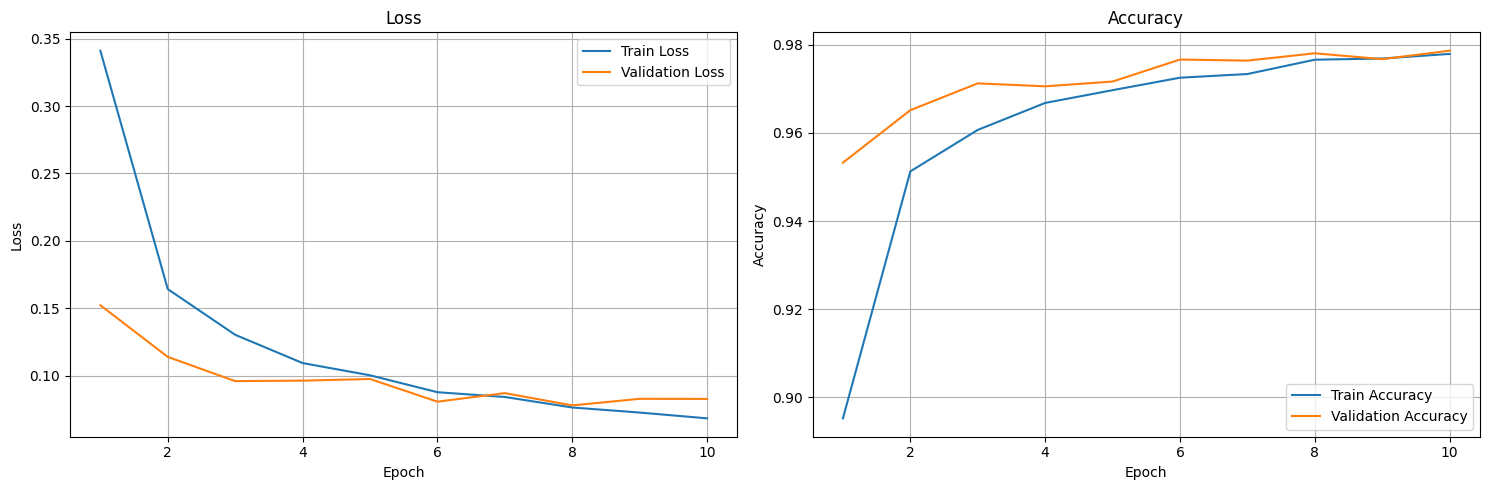

In [ ]:
trainer.plot_history(history)

# Load model

In [ ]:
did_load_best = trainer.load_model("best_model.pt")

Model loaded from /content/drive/MyDrive/mmml/project/model_mnist_dense/best_model.pt


In [ ]:
evaluate_model(model, test_loader, criterion, device, num_classes)


--- Test Set Evaluation ---
Test Loss: 0.0708, Test Accuracy: 0.9787 (9787/10000)

Class-specific Accuracy:
  Class 0: 98.88% (969/980)
  Class 1: 99.30% (1127/1135)
  Class 2: 98.06% (1012/1032)
  Class 3: 97.92% (989/1010)
  Class 4: 98.37% (966/982)
  Class 5: 97.53% (870/892)
  Class 6: 98.23% (941/958)
  Class 7: 97.08% (998/1028)
  Class 8: 97.74% (952/974)
  Class 9: 95.44% (963/1009)


(0.07080007054808084, 0.9787)

Predictions visualization saved to /content/drive/MyDrive/mmml/project/model_mnist_dense/predictions.png


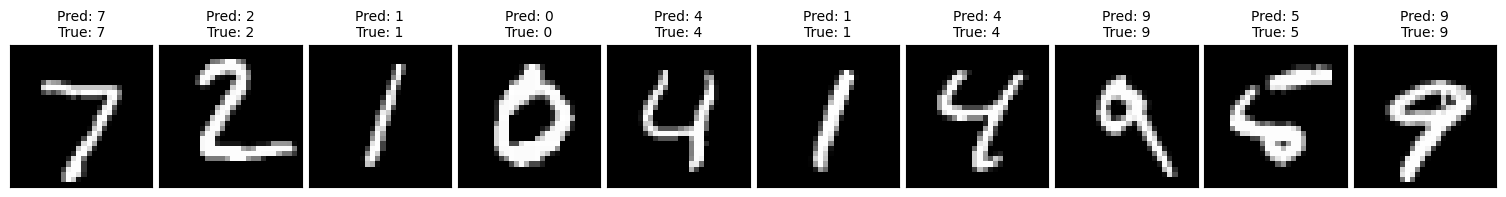

In [ ]:
visualize_predictions(model, test_loader, device, num_samples=10, save_dir=run_save_dir)

# SVD

## Model

In [ ]:
class SVDLinear(nn.Module):
    def __init__(self, u: torch.Tensor, s_vec: torch.Tensor, v_t: torch.Tensor, bias: torch.Tensor | None):
        super().__init__()
        self.out_features, self.rank = u.shape
        self.in_features = v_t.shape[1]

        self.u = nn.Parameter(u.clone().detach())
        self.s_vec = nn.Parameter(s_vec.clone().detach())
        self.v_t = nn.Parameter(v_t.clone().detach())

        if bias is not None:
            self.bias = nn.Parameter(bias.clone().detach())
        else:
            self.register_parameter('bias', None)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Linear does x @ W^T + b, so we need also to do x @ (USV^T)^T or U^TS^TV
        x_v = torch.matmul(x, self.v_t.t())
        x_v_s = x_v * self.s_vec
        y = torch.matmul(x_v_s, self.u.t())
        if self.bias is not None:
            y = y + self.bias
        return y

    def __repr__(self):
        return f"SVDLinear(in_features={self.in_features}, out_features={self.out_features}, rank={self.rank}, bias={self.bias is not None})"

class SVDModel(nn.Module):
    def __init__(self, dense_model: DenseNetwork, information_preserved: float = 0.99, print_more: bool = False):
        super().__init__()
        svd_layers = []
        device = next(dense_model.parameters()).device

        if information_preserved < 0 or information_preserved > 1:
            raise ValueError("information_preserved must be in (0; 1]")

        dense_model.eval() # freeze all params of original

        with torch.no_grad():
            for i, layer in enumerate(dense_model.sequential):
                if not isinstance(layer, nn.Linear):
                    svd_layers.append(layer)
                    continue
                weight = layer.weight.data
                bias = layer.bias.data if layer.bias is not None else None

                # full_matrices=False => will already remove all 0 eigvals
                u, s_vec, v_t = torch.linalg.svd(weight, full_matrices=False)

                k_full = s_vec.shape[0]
                rank = k_full
                s_squared = s_vec**2
                threshold_variance = torch.sum(s_squared) * information_preserved
                if threshold_variance == 0: # if weight is zero
                    rank = 1
                else:
                    cumulative_variance = torch.cumsum(s_squared, dim=0)
                    rank_candidates = torch.where(cumulative_variance >= threshold_variance)[0]
                    rank = rank_candidates[0].item() + 1
                if print_more:
                    if rank < k_full:
                        print(f"Truncating rank from {k_full} to {rank}")
                    else:
                        print(f"Keeping full rank {k_full}")

                u_k = u[:, :rank]
                s_k_vec = s_vec[:rank]
                v_t_k = v_t[:rank, :]

                svd_linear_layer = SVDLinear(u_k, s_k_vec, v_t_k, bias)
                svd_layers.append(svd_linear_layer)
        self.sequential = nn.Sequential(*svd_layers)

    def forward(self, x):
        return self.sequential(x)

## Eval 0.99

In [ ]:
svd_model = SVDModel(model, print_more=True)

Truncating rank from 256 to 211
Truncating rank from 128 to 109
Keeping full rank 10


In [ ]:
evaluate_model(svd_model, test_loader, criterion, device, num_classes)


--- Test Set Evaluation ---
Test Loss: 0.0709, Test Accuracy: 0.9790 (9790/10000)

Class-specific Accuracy:
  Class 0: 98.88% (969/980)
  Class 1: 99.30% (1127/1135)
  Class 2: 97.97% (1011/1032)
  Class 3: 98.02% (990/1010)
  Class 4: 98.57% (968/982)
  Class 5: 97.53% (870/892)
  Class 6: 98.23% (941/958)
  Class 7: 97.18% (999/1028)
  Class 8: 97.64% (951/974)
  Class 9: 95.54% (964/1009)


(0.07092463949871017, 0.979)

Predictions visualization saved to /content/drive/MyDrive/mmml/project/model_mnist_dense/predictions.png


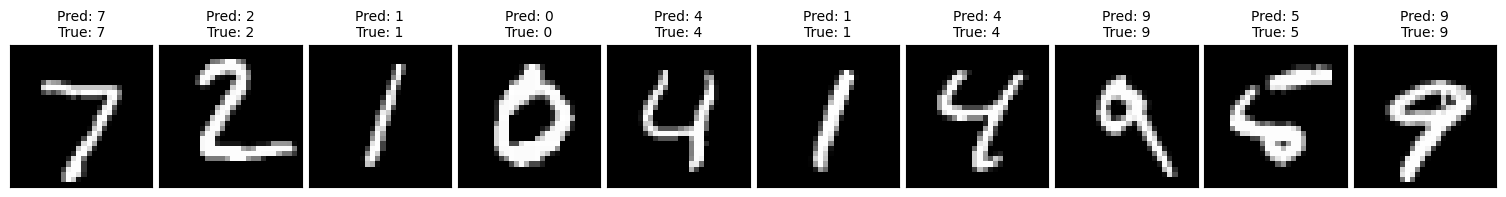

In [ ]:
visualize_predictions(svd_model, test_loader, device, num_samples=10, save_dir=run_save_dir)

## Compromise

In [ ]:
compare_models(model, test_loader, criterion, device, num_classes, lambda coef: SVDModel(model, coef), [0.99, 0.95, 0.91, 0.87, 0.83, 0.79, 0.75, 0.71, 0.67], "Info preserved")

| Info preserved | Size (MiB) | Size (% of orig) | Loss  | Accuracy |
| Original model | 0.897      | 100%             | 0.071 | 0.979    |
| 99.000000%     | 1.005      | 112.016%         | 0.071 | 0.979    |
| 95.000000%     | 0.649      | 72.350%          | 0.079 | 0.976    |
| 91.000000%     | 0.467      | 52.078%          | 0.087 | 0.974    |
| 87.000000%     | 0.354      | 39.489%          | 0.086 | 0.974    |
| 83.000000%     | 0.275      | 30.709%          | 0.098 | 0.970    |
| 79.000000%     | 0.222      | 24.693%          | 0.101 | 0.969    |
| 75.000000%     | 0.179      | 19.946%          | 0.212 | 0.929    |
| 71.000000%     | 0.152      | 16.914%          | 0.235 | 0.920    |
| 67.000000%     | 0.125      | 13.987%          | 0.337 | 0.889    |


For mnist, it seems, 87% info preserved is quite optimal, if we do not want to lose any accuracy. It only loses 0.5% points in accuracy (97.4%), while having 64.2% of the original size.

If we are willing to compromise a bit, we can choose even 79% info preserved. The model size is 24.7%, and the accuracy is 1% point less (96.9%) When compressing the model even more, the performance starts decreasing drastically, as each new principal axis holds more significant value.

# Parameter pruning

## Pruned Layer

In [ ]:
class PrunedLayer(nn.Module):
    def __init__(self, weight: torch.Tensor, bias: torch.Tensor | None, preserved_ids: torch.Tensor, output_dim: int):
        super().__init__()
        self.weight = nn.Parameter(weight.clone().detach())
        self.bias = nn.Parameter(bias.clone().detach()) if bias is not None else None
        self.preserved_ids = preserved_ids
        self.output_dim = output_dim

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        y = torch.matmul(x, self.weight.t())
        if self.bias is not None:
            y = y + self.bias
        zero_full_vector = torch.zeros(x.shape[0], self.output_dim, device=x.device)
        zero_full_vector[:, self.preserved_ids] = y
        return zero_full_vector

## Post training

### Model

In [ ]:
class PrunedPostTrainingModel(nn.Module):
    def __init__(self, dense_model: DenseNetwork, information_preserved: float = 0.99):
        super().__init__()
        pruned_layers = []
        device = next(dense_model.parameters()).device

        dense_model.eval() # freeze all params of original

        with torch.no_grad():
            last_linear_layer = None
            for i, layer in enumerate(dense_model.sequential):
                if isinstance(layer, nn.Linear):
                    last_linear_layer = i
            for i, layer in enumerate(dense_model.sequential):
                if not isinstance(layer, nn.Linear):
                    pruned_layers.append(layer)
                    continue
                weight = layer.weight.data
                bias = layer.bias.data if layer.bias is not None else None

                output_dim = weight.shape[0]
                preserve_k = int(output_dim * information_preserved) if i != last_linear_layer else output_dim

                row_sum_squared = torch.sum(torch.square(weight), dim=1)
                sorted_rows = torch.argsort(row_sum_squared, descending=True)
                preserved_ids = sorted_rows[:preserve_k]

                pruned_weight = weight[preserved_ids, :]
                pruned_bias = bias[preserved_ids] if bias is not None else None
                pruned_layer = PrunedLayer(pruned_weight, pruned_bias, preserved_ids, output_dim)
                pruned_layers.append(pruned_layer)
        self.sequential = nn.Sequential(*pruned_layers)

    def forward(self, x):
        return self.sequential(x)

### Eval 0.99

In [ ]:
pruned_model = PrunedPostTrainingModel(model, information_preserved=0.99)

In [ ]:
evaluate_model(pruned_model, test_loader, criterion, device, num_classes)


--- Test Set Evaluation ---
Test Loss: 0.0709, Test Accuracy: 0.9787 (9787/10000)

Class-specific Accuracy:
  Class 0: 98.88% (969/980)
  Class 1: 99.30% (1127/1135)
  Class 2: 98.06% (1012/1032)
  Class 3: 97.92% (989/1010)
  Class 4: 98.37% (966/982)
  Class 5: 97.53% (870/892)
  Class 6: 98.23% (941/958)
  Class 7: 96.98% (997/1028)
  Class 8: 97.74% (952/974)
  Class 9: 95.54% (964/1009)


(0.07089371852596524, 0.9787)

### Compromise

In [ ]:
compare_models(model, test_loader, criterion, device, num_classes, lambda coef: PrunedPostTrainingModel(model, coef), [0.99, 0.93, 0.87, 0.81, 0.75, 0.69, 0.63, 0.57, 0.51, 0.45], "Neurons preserved")

| Neurons preserved | Size (MiB) | Size (% of orig) | Loss  | Accuracy |
| Original model    | 0.897      | 100%             | 0.071 | 0.979    |
| 99.000000%        | 0.886      | 98.780%          | 0.071 | 0.979    |
| 93.000000%        | 0.834      | 93.007%          | 0.070 | 0.979    |
| 87.000000%        | 0.779      | 86.792%          | 0.074 | 0.978    |
| 81.000000%        | 0.726      | 80.910%          | 0.081 | 0.977    |
| 75.000000%        | 0.674      | 75.137%          | 0.091 | 0.973    |
| 69.000000%        | 0.618      | 68.921%          | 0.127 | 0.969    |
| 63.000000%        | 0.565      | 63.040%          | 0.170 | 0.963    |
| 57.000000%        | 0.510      | 56.824%          | 0.253 | 0.954    |
| 51.000000%        | 0.458      | 51.051%          | 0.444 | 0.884    |
| 45.000000%        | 0.405      | 45.169%          | 0.562 | 0.869    |


For mnist, it seems, approximately 75% neurons preserved is quite optimal, if we do not want to lose any accuracy. It only loses 0.6% points in accuracy (97%), while having 75.1% of the original size.

If we are willing to compromise a bit, we can choose even 69% neurons preserved (*nice*). The model size is 68.9%, and the accuracy is 1% point less (96.9%).


## During training

### Model

In [ ]:
class PrunedDuringTrainingModel(nn.Module):
    def __init__(self, dense_model: DenseNetwork, copy_model: bool = True):
        super().__init__()

        device = next(dense_model.parameters()).device
        if copy_model:
            self.model = copy.deepcopy(dense_model)
        else:
            self.model = dense_model
        self.total_grads = {}

        layers = []

        self.model.eval() # freeze all params of original

        with torch.no_grad():
            for i, layer in enumerate(self.model.sequential):
                layers.append(layer)
                if isinstance(layer, nn.Linear) and layer.weight.requires_grad:
                    self.total_grads[i] = torch.zeros_like(layer.weight)

        self.sequential = nn.Sequential(*layers)

    def forward(self, x):
        return self.sequential(x)

    def accumulate_gradients(self):
        for i, layer in enumerate(self.sequential):
            if isinstance(layer, nn.Linear) and layer.weight.requires_grad and layer.weight.grad is not None:
                self.total_grads[i] += layer.weight.grad.clone()

    def reset_grads(self):
        for i in self.total_grads:
            self.total_grads[i].zero_()

    def get_pruned(self, information_preserved: float = 0.99) -> DenseNetwork:
        new_layers = []
        with torch.no_grad():
            last_linear_layer = None
            for i, layer in enumerate(self.sequential):
                if isinstance(layer, nn.Linear):
                    last_linear_layer = i
            for i, layer in enumerate(self.sequential):
                if not isinstance(layer, nn.Linear):
                    new_layers.append(layer)
                    continue
                weight = layer.weight.data
                bias = layer.bias.data if layer.bias is not None else None

                output_dim = weight.shape[0]
                preserve_k = int(output_dim * information_preserved) if i != last_linear_layer else output_dim

                row_sum_squared = torch.sum(torch.square(self.total_grads[i]), dim=1)
                sorted_rows = torch.argsort(row_sum_squared, descending=True)
                preserved_ids = sorted_rows[:preserve_k]

                pruned_weight = weight[preserved_ids, :]
                pruned_bias = bias[preserved_ids] if bias is not None else None
                pruned_layer = PrunedLayer(pruned_weight, pruned_bias, preserved_ids, output_dim)
                new_layers.append(pruned_layer)
        new_model = copy.deepcopy(self.model)
        new_model.sequential = nn.Sequential(*new_layers)
        return new_model

### Eval 0.99

In [ ]:
model_to_be_pruned = DenseNetwork(
    input_dim=input_dim,
    hidden_dims=HIDDEN_DIMS,
    output_dim=output_dim,
    dropout_rate=DROPOUT_RATE
).to(device)
pruner_model = PrunedDuringTrainingModel(model_to_be_pruned)

In [ ]:
pruner_criterion = nn.CrossEntropyLoss()
pruner_optimizer = optim.Adam(pruner_model.parameters(), lr=LEARNING_RATE)
pruner_trainer = ModelTrainer(
    model=pruner_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=pruner_criterion,
    optimizer=pruner_optimizer,
    device=device,
    save_dir=None
)
history = pruner_trainer.train(epochs=EPOCHS, early_stopping_patience=EARLY_STOPPING_PATIENCE, accumulate_gradients=True)

Model will not be saved to disk
Epoch 1/10: Train Loss: 0.3354, Train Acc: 0.8969, Val Loss: 0.1361, Val Acc: 0.9594
Epoch 2/10: Train Loss: 0.1616, Train Acc: 0.9519, Val Loss: 0.1171, Val Acc: 0.9644
Epoch 3/10: Train Loss: 0.1297, Train Acc: 0.9609, Val Loss: 0.0953, Val Acc: 0.9709
Epoch 4/10: Train Loss: 0.1114, Train Acc: 0.9666, Val Loss: 0.0913, Val Acc: 0.9728
Epoch 5/10: Train Loss: 0.0931, Train Acc: 0.9711, Val Loss: 0.0920, Val Acc: 0.9726
Epoch 6/10: Train Loss: 0.0886, Train Acc: 0.9723, Val Loss: 0.0890, Val Acc: 0.9752
Epoch 7/10: Train Loss: 0.0797, Train Acc: 0.9755, Val Loss: 0.0842, Val Acc: 0.9765
Epoch 8/10: Train Loss: 0.0766, Train Acc: 0.9760, Val Loss: 0.0780, Val Acc: 0.9783
Epoch 9/10: Train Loss: 0.0717, Train Acc: 0.9771, Val Loss: 0.0848, Val Acc: 0.9758
Epoch 10/10: Train Loss: 0.0675, Train Acc: 0.9776, Val Loss: 0.0701, Val Acc: 0.9807


In [ ]:
evaluate_model(pruner_model, test_loader, pruner_criterion, device, num_classes)


--- Test Set Evaluation ---
Test Loss: 0.0670, Test Accuracy: 0.9799 (9799/10000)

Class-specific Accuracy:
  Class 0: 98.88% (969/980)
  Class 1: 99.30% (1127/1135)
  Class 2: 97.97% (1011/1032)
  Class 3: 97.92% (989/1010)
  Class 4: 97.86% (961/982)
  Class 5: 97.42% (869/892)
  Class 6: 98.23% (941/958)
  Class 7: 96.89% (996/1028)
  Class 8: 97.84% (953/974)
  Class 9: 97.42% (983/1009)


(0.06703723769329954, 0.9799)

In [ ]:
pruned_model = pruner_model.get_pruned()

In [ ]:
evaluate_model(pruned_model, test_loader, pruner_criterion, device, num_classes)


--- Test Set Evaluation ---
Test Loss: 0.0670, Test Accuracy: 0.9801 (9801/10000)

Class-specific Accuracy:
  Class 0: 98.78% (968/980)
  Class 1: 99.30% (1127/1135)
  Class 2: 98.26% (1014/1032)
  Class 3: 97.92% (989/1010)
  Class 4: 97.66% (959/982)
  Class 5: 97.42% (869/892)
  Class 6: 98.23% (941/958)
  Class 7: 96.89% (996/1028)
  Class 8: 98.05% (955/974)
  Class 9: 97.42% (983/1009)


(0.06695008369657444, 0.9801)

### Compromise

In [ ]:
compare_models(model, test_loader, pruner_criterion, device, num_classes, lambda coef: pruner_model.get_pruned(coef), [0.99, 0.93, 0.87, 0.81, 0.75, 0.69, 0.63, 0.57, 0.51, 0.41, 0.36, 0.25, 0.2, 0.15], "Neurons preserved")

| Neurons preserved | Size (MiB) | Size (% of orig) | Loss  | Accuracy |
| Original model    | 0.897      | 100%             | 0.071 | 0.979    |
| 99.000000%        | 0.886      | 98.780%          | 0.067 | 0.980    |
| 93.000000%        | 0.834      | 93.007%          | 0.067 | 0.980    |
| 87.000000%        | 0.779      | 86.792%          | 0.067 | 0.979    |
| 81.000000%        | 0.726      | 80.910%          | 0.072 | 0.978    |
| 75.000000%        | 0.674      | 75.137%          | 0.077 | 0.977    |
| 69.000000%        | 0.618      | 68.921%          | 0.093 | 0.974    |
| 63.000000%        | 0.565      | 63.040%          | 0.123 | 0.966    |
| 57.000000%        | 0.510      | 56.824%          | 0.149 | 0.968    |
| 51.000000%        | 0.458      | 51.051%          | 0.202 | 0.960    |
| 41.000000%        | 0.367      | 40.951%          | 0.485 | 0.916    |
| 36.000000%        | 0.326      | 36.289%          | 0.677 | 0.860    |
| 25.000000%        | 0.228      | 25.411%         

On small compression pruning during training seems to behave pretty similarly to SVD (e.g. at 75% of size it has 97.7% accuracy, while SVD at 72.4% has 97.6% accuracy). However, with the increase of pruned neurons, the accuracy degrades significantly more (e.g. 68.9% vs 96.9% at 25% size).

# LORA

## Model

In [11]:
class LoRALinear(nn.Module):
  def __init__(self, input_dim, output_dim, rank=4, alpha=1.0, dropout=0.0, bias=True):
    super().__init__()
    self.input_dim = input_dim
    self.output_dim = output_dim
    self.rank = rank

    self.LORA_A = nn.Parameter(torch.zeros((input_dim, rank)))
    self.LORA_B = nn.Parameter(torch.zeros((rank, output_dim)))
    nn.init.normal_(self.LORA_A, mean=0, std=1)
    # nn.init.kaiming_uniform_(self.LORA_A, a=math.sqrt(5))
    nn.init.zeros_(self.LORA_B)

    self.bias = bias
    self.scale = alpha / rank

    self.linear = nn.Linear(input_dim, output_dim, bias=bias)

    if dropout > 0:
      self.dropout = nn.Dropout(dropout)
    else:
      self.dropout = nn.Identity()

    self.enabled = True

  def forward(self, x):
    out = self.linear(x)
    if self.enabled:
      lora_out = (self.dropout(x) @ self.LORA_A) @ self.LORA_B
      return out + lora_out * self.scale
    return out

  def __repr__(self):
      return f"LoRALinear(in_features={self.input_dim}, out_features={self.output_dim}, rank={self.rank}, bias={self.bias is not None})"

In [12]:
class LoRAModel(nn.Module):
  def __init__(self, dense_model: DenseNetwork, rank=4, alpha=1.0, dropout=0.0):
        super().__init__()
        lora_layers = []
        device = next(dense_model.parameters()).device
        self.model = dense_model

        dense_model.eval()

        for param in self.model.parameters():
            param.requires_grad = False

        with torch.no_grad():
            for layer in dense_model.sequential:
                if not isinstance(layer, nn.Linear):
                    lora_layers.append(layer)
                    continue

                weight = layer.weight.data
                bias = layer.bias.data if layer.bias is not None else None


                lora_layer = LoRALinear(layer.in_features, layer.out_features,
                                        rank = rank, alpha = alpha,
                                        dropout = dropout, bias=(layer.bias is not None))

                lora_layer.linear.weight.data.copy_(layer.weight.data)
                if layer.bias is not None:
                    lora_layer.linear.bias.data.copy_(layer.bias.data)

                lora_layer.linear.weight.requires_grad = False
                if layer.bias is not None:
                    lora_layer.linear.bias.requires_grad = False
                lora_layers.append(lora_layer.to(device))

            self.sequential = nn.Sequential(*lora_layers)

  def forward(self, x):
        return self.sequential(x)

## Split dataset

In [13]:
classes_to_keep = list(range(2, 10))

train_dataset_filtered = get_class_subset(train_dataset, classes_to_keep)
val_dataset_filtered = get_class_subset(val_dataset, classes_to_keep)

train_loader_filtered = DataLoader(train_dataset_filtered, batch_size=BATCH_SIZE, shuffle=True,
                         num_workers=2, pin_memory=True if device=="cuda" else False)
val_loader_filtered = DataLoader(val_dataset_filtered, batch_size=BATCH_SIZE, shuffle=False,
                       num_workers=2, pin_memory=True if device=="cuda" else False)


## Pre-train

In [39]:
model_to_lora = DenseNetwork(
    input_dim=input_dim,
    hidden_dims=[1024, 512],
    output_dim=output_dim,
    dropout_rate=DROPOUT_RATE
).to(device)

In [40]:
lora_criterion = nn.CrossEntropyLoss()
lora_optimizer = optim.Adam(model_to_lora.parameters(), lr=LEARNING_RATE)
lora_trainer = ModelTrainer(
    model=model_to_lora,
    train_loader=train_loader_filtered,
    val_loader=val_loader_filtered,
    criterion=lora_criterion,
    optimizer=lora_optimizer,
    device=device,
    save_dir=None
)
history = lora_trainer.train(epochs=4, early_stopping_patience=EARLY_STOPPING_PATIENCE)

Model will not be saved to disk
Epoch 1/4: Train Loss: 0.2645, Train Acc: 0.9141, Val Loss: 0.1378, Val Acc: 0.9592
Epoch 2/4: Train Loss: 0.1301, Train Acc: 0.9590, Val Loss: 0.1166, Val Acc: 0.9643
Epoch 3/4: Train Loss: 0.1045, Train Acc: 0.9671, Val Loss: 0.1135, Val Acc: 0.9651
Epoch 4/4: Train Loss: 0.0882, Train Acc: 0.9719, Val Loss: 0.0935, Val Acc: 0.9733


In [41]:
evaluate_model(model_to_lora, test_loader, lora_criterion, device, num_classes)


--- Test Set Evaluation ---
Test Loss: 2.6842, Test Accuracy: 0.7678 (7678/10000)

Class-specific Accuracy:
  Class 0: 0.00% (0/980)
  Class 1: 0.00% (0/1135)
  Class 2: 98.74% (1019/1032)
  Class 3: 98.61% (996/1010)
  Class 4: 97.25% (955/982)
  Class 5: 96.64% (862/892)
  Class 6: 97.70% (936/958)
  Class 7: 96.79% (995/1028)
  Class 8: 95.79% (933/974)
  Class 9: 97.32% (982/1009)


(2.6842142528533937, 0.7678)

## Post-train

In [42]:
copy_model = copy.deepcopy(model_to_lora)
lora_model = LoRAModel(model_to_lora, rank=2, alpha=0.5, dropout=0)

In [43]:
lora_criterion = nn.CrossEntropyLoss()
lora_optimizer = optim.Adam(lora_model.parameters(), lr=LEARNING_RATE)
lora_trainer = ModelTrainer(
    model=lora_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=lora_criterion,
    optimizer=lora_optimizer,
    device=device,
    save_dir=None
)

Model will not be saved to disk


In [44]:
%time history = lora_trainer.train(epochs=4, early_stopping_patience=EARLY_STOPPING_PATIENCE)

Epoch 1/4: Train Loss: 0.3475, Train Acc: 0.9419, Val Loss: 0.0992, Val Acc: 0.9722
Epoch 2/4: Train Loss: 0.0878, Train Acc: 0.9745, Val Loss: 0.0919, Val Acc: 0.9732
Epoch 3/4: Train Loss: 0.0811, Train Acc: 0.9764, Val Loss: 0.0850, Val Acc: 0.9745
Epoch 4/4: Train Loss: 0.0710, Train Acc: 0.9790, Val Loss: 0.0836, Val Acc: 0.9758
CPU times: user 46.5 s, sys: 2.02 s, total: 48.6 s
Wall time: 1min 23s


In [45]:
evaluate_model(lora_model, test_loader, lora_criterion, device, num_classes)


--- Test Set Evaluation ---
Test Loss: 0.0757, Test Accuracy: 0.9782 (9782/10000)

Class-specific Accuracy:
  Class 0: 98.16% (962/980)
  Class 1: 99.21% (1126/1135)
  Class 2: 97.48% (1006/1032)
  Class 3: 98.51% (995/1010)
  Class 4: 97.86% (961/982)
  Class 5: 97.98% (874/892)
  Class 6: 97.29% (932/958)
  Class 7: 97.18% (999/1028)
  Class 8: 96.82% (943/974)
  Class 9: 97.52% (984/1009)


(0.07572025874904358, 0.9782)

LoRA great it trains and gets smorter

It learns classes it did not see previously

In [46]:
copy_optimizer = optim.Adam(copy_model.parameters(), lr=LEARNING_RATE)
copy_trainer = ModelTrainer(
    model=copy_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=lora_criterion,
    optimizer=copy_optimizer,
    device=device,
    save_dir=None
)

Model will not be saved to disk


In [47]:
%time history = copy_trainer.train(epochs=4, early_stopping_patience=EARLY_STOPPING_PATIENCE)

Epoch 1/4: Train Loss: 0.1397, Train Acc: 0.9624, Val Loss: 0.0941, Val Acc: 0.9728
Epoch 2/4: Train Loss: 0.0850, Train Acc: 0.9746, Val Loss: 0.0934, Val Acc: 0.9753
Epoch 3/4: Train Loss: 0.0764, Train Acc: 0.9774, Val Loss: 0.0885, Val Acc: 0.9778
Epoch 4/4: Train Loss: 0.0720, Train Acc: 0.9784, Val Loss: 0.0912, Val Acc: 0.9764
CPU times: user 1min 32s, sys: 2.19 s, total: 1min 34s
Wall time: 1min 59s
